# RP3 — Mathematics Notebook (Energy Resource Modelling)

**What this notebook is:** a guided, self-contained mathematics + data notebook to support your project write-up.  
You will use calculus (integrals), differential equations (ODEs), and numerical methods (numerical integration, numerical ODE solving) to model an energy resource and explore “what-if” scenarios relevant to your assigned technology.

**What you will submit:**  
1. This notebook, **completed and run end-to-end** (all cells executed, no errors).  
2. The notebook must be stored in a **public GitHub repository** shared among all group members (one repo per group).  
   - Include a short `README.md` describing what you did and how to run the notebook.
   - Everyone in the group should have access and should contribute.

**Use in your write-up:**  
You are **encouraged (not required)** to incorporate figures, calculations, and conclusions from this notebook into your final project submission. If you do, cite your GitHub repo and refer to the relevant sections/cells.

---

## Technologies supported in this notebook

- Fermentation  
- Water  
- Solar  
- Wind  
- Nuclear fission  
- Geothermal  

You will choose **one** technology below corresponding to your Phase 2 assignment, and the notebook will follow the appropriate branch.


In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

DATA_DIR = Path("data")  # assumes you keep the data folder next to this notebook

TECH_OPTIONS = ["Fermentation","Water","Solar","Wind","Nuclear Fission","Geothermal"]
TECH = "Fermentation"  # <-- CHANGE ME

assert TECH in TECH_OPTIONS, f"TECH must be one of {TECH_OPTIONS}"
TECH

'Fermentation'

## About the data

To keep difficulty equitable across groups, this notebook ships with datasets for each technology.

- **Solar & Wind** use hourly weather data for 2025 from **Open-Meteo** (Hamilton coordinates), including wind speed and solar radiation.  
  Reference: Open-Meteo Historical Weather API documentation.

- **Fermentation** uses a **small sample** derived from the NYC DEP “Wastewater Co-digestion and Biogas-to-grid Performance Indicators” *schema* and plausible ranges.
  - This is included so you can proceed immediately and practice the methods.
  - If you want to swap in the full official dataset later, a short “how-to” link is provided below.

- **Water, Nuclear, Geothermal** are provided as **representative time series** bundled with this notebook so every group can proceed uniformly.
  - These are intentionally “clean” datasets so your effort is focused on modelling and interpretation.
  - If you locate high-quality primary data for your specific case study, you can replace these files without changing the notebook logic.

**Key point:** You do *not* need to hunt for data to complete the notebook. **Optionally:** you may wish to use data that you are able to find which is more specific to your region. This is encouraged, but not required. If you would like to use your own sourced data, please seek approval from your instructor.

**References**
- Open-Meteo docs: https://open-meteo.com/en/docs/historical-weather-api  
- NYC dataset landing page (biogas): https://catalog.data.gov/dataset/wastewater-co-digestion-and-biogas-to-grid-performance-indicators  


In [3]:
def load_data_for_tech(tech: str) -> pd.DataFrame:
    """Load the packaged dataset associated with a technology choice."""
    if tech in ["Solar","Wind"]:
        return pd.read_csv(DATA_DIR / "hamilton_2025_wind_solar_openmeteo.csv", parse_dates=["time"])
    if tech == "Fermentation":
        return pd.read_csv(DATA_DIR / "nyc_wrrf_biogas_monthly_sample.csv")
    if tech == "Water":
        return pd.read_csv(DATA_DIR / "water_daily_flow_synthetic_2025.csv", parse_dates=["date"])
    if tech == "Nuclear Fission":
        return pd.read_csv(DATA_DIR / "nuclear_hourly_synthetic_2025.csv", parse_dates=["time"])
    if tech == "Geothermal":
        return pd.read_csv(DATA_DIR / "geothermal_hourly_synthetic_2025.csv", parse_dates=["time"])
    raise ValueError(f"Unknown tech: {tech}")

df = load_data_for_tech(TECH)
df.head()


,facility,year,month,sludge_digested_wet_tons,food_scraps_digested_wet,rng_production_mmbtu,rng_system_uptime
0,Newtown Creek,2023,January,64794.29,4892.79,17019.44,0.29
1,Newtown Creek,2023,February,68985.76,5180.89,8251.41,0.50
2,Newtown Creek,2023,March,59134.41,5272.02,8426.74,0.30
3,Newtown Creek,2023,April,66784.51,5799.31,9224.47,0.36
4,Newtown Creek,2023,May,70795.41,5961.38,15927.66,0.45


## Phase 1 — Characterize the resource with calculus and data

In Phase 1 you will:

1. Use **Pandas** to summarize the dataset.
2. Use **numerical integration** (e.g., the trapezoid rule) to convert a *power or rate* time series into an *energy or total amount* over a period (Section 7.7 in Edition 9 of the textbook).
3. Build a **first-pass model** that maps “measured variables” → “power output”.

A recurring mathematical idea is:

> If $P(t)$ is power (Watts) at time $t$, then total energy over $[t_0,t_1]$ is  
> $$
E = \int_{t_0}^{t_1} P(t)\,dt.
$$
With discrete data, we approximate the integral numerically.

### Numerical integration (trapezoid rule)
If we have values $P_0,P_1,\dots,P_n$ at equally spaced times with spacing $\Delta t$, then
$$
\int P(t)\,dt \approx \Delta t\Big(\tfrac{1}{2}P_0 + P_1 + \cdots + P_{n-1} + \tfrac{1}{2}P_n\Big).
$$

Implement this below using a loop:


In [4]:
def trapz_integral(y: np.ndarray, dt: float) -> float: #y is what you are integrating, dt is the spacing
    """Approximate integral of y(t) dt using trapezoid rule for evenly-spaced samples."""
    integral = 0.00
    integral += 0.5*y[0]*dt
    integral += 0.5*y[-1]*dt
    
    for i in range (1, len(y)-1):
        integral += (y[i])* dt
    
    return integral

# quick demo on a known function: integral of sin from 0 to pi is 2
# We can test this against numpy's built-in trapezoid rule implementation
x = np.linspace(0, np.pi, 100)
y = np.sin(x)
dx = x[1] - x[0]
your_result = trapz_integral(y, dx)
numpy_result = np.trapezoid(y, dx=dx)
print(f"Our result: {your_result}, Numpy result: {numpy_result}")


Our result: 1.999832163893992, Numpy result: 1.9998321638939927


### Check 1 (embedded)

This is a quick self-check. It is not separately graded, but you should keep checks passing.


In [5]:
# Check 1: integral of sin from 0 to pi should be close to 2
assert type(your_result) != float, "trapz_integral should return a float"
assert abs(your_result - 2.0) < 1e-3
"Check 1 passed" 

'Check 1 passed'

## Branch: Solar

### Physical idea

Open-Meteo provides **shortwave radiation** $I(t)$ in W/m². A simple PV model is:
$$
P(t) = \eta\,A\,I(t)
$$
where
- $\eta$ = overall efficiency (panel + inverter + losses), dimensionless
- $A$ = panel area (m²)
- $I(t)$ = incident irradiance (W/m²)

This is an intentionally simple model. Real PV modelling can incorporate tilt, temperature derating, shading, etc.  
If you want to go deeper, see NREL PVWatts (reference link):
- https://pvwatts.nrel.gov/

### Your task

1. Pick a plausible array size (area) and efficiency and justify briefly in markdown.
2. Compute hourly power output $P(t)$.
3. Compute annual energy in kWh using numerical integration.
4. Create at least one plot that supports an interpretation.



In [6]:
if TECH == "Solar":
    df_ws = df.copy()
    # Parameters (edit these!!!!)
    eta = np.nan  # TODO: choose and justify overall efficiency (dimensionless)
    area_m2 = np.nan  # TODO: choose and justify panel area (m^2)

    if np.isnan(eta) or np.isnan(area_m2):
        raise ValueError("Set eta and area_m2 (and justify) before running the Solar branch.")

    I = df_ws["shortwave_radiation_W_m2"].to_numpy()
    P_W = np.nan #Compute power in Watts from I, eta, and area_m2
    df_ws["power_W"] = P_W

    # Energy (Wh) = integral of W over hours; dt = 3600 seconds
    E_Wh = trapz_integral(P_W, dt_seconds=3600.0) / 3600.0
    E_kWh = E_Wh / 1000.0

    print(f"Estimated annual energy: {E_kWh:,.0f} kWh")

    # Plot a 7-day window
    window = df_ws.iloc[0:24*7].copy()
    plt.figure()
    plt.plot(window["time"], window["power_W"])
    plt.title("Solar power estimate (first 7 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Wind

### Physical idea

Wind turbines convert kinetic energy in moving air into electrical power. A very simplified model:
$$
P(t) = \tfrac{1}{2}\,\rho\,A\,C_p\,v(t)^3
$$
where
- $\rho$ = air density (kg/m³), about 1.2 at sea level
- $A$ = swept area of the rotor (m²)
- $C_p$ = power coefficient (dimensionless), bounded above by the Betz limit (~0.593); practical values are lower
- $v(t)$ = wind speed (m/s)

Real turbines have cut-in / rated / cut-out speeds and a manufacturer power curve.

Reference:  
- https://en.wikipedia.org/wiki/Wind_turbine_aerodynamics  
- (For a more technical and reputable engineering overview) NREL wind basics: https://www.nrel.gov/research/re-wind.html

### Your task

1. Choose reasonable parameters (rotor radius, $C_p$, etc.) and justify.
2. Compute a power time series and annual energy.
3. Add at least one plot and interpret.



In [7]:
if TECH == "Wind":
    df_ws = df.copy()
    rho = np.nan  # TODO: air density (kg/m^3)
    Cp = np.nan  # TODO: power coefficient (dimensionless)
    radius_m = np.nan  # TODO: rotor radius (m)
    if np.isnan(rho) or np.isnan(Cp) or np.isnan(radius_m) or np.isnan(rated_power_W):
        raise ValueError("Set rho, Cp, radius_m, rated_power_W (and justify) before running the Wind branch.")

    A = np.pi * radius_m**2 # rotor swept area (m^2)

    v = df_ws["windspeed_10m_m_s"].to_numpy()
    P_W = np.nan # TODO: compute wind power in Watts using rho, A, Cp, and v 

    # Optional (recommended): cap at a rated power to avoid absurd values in this toy model
    rated_power_W = np.nan  # TODO: rated power cap (W)
    P_W = np.minimum(P_W, rated_power_W)

    df_ws["power_W"] = P_W
    E_kWh = (trapz_integral(P_W, 3600.0) / 3600.0) / 1000.0
    print(f"Estimated annual energy: {E_kWh:,.0f} kWh")

    window = df_ws.iloc[0:24*7].copy()
    plt.figure()
    plt.plot(window["time"], window["power_W"])
    plt.title("Wind power estimate (first 7 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Fermentation (energy from biogas / RNG)

### What the dataset represents
The included file is a monthly table (year, month) with fields aligned to a wastewater co-digestion + RNG context, including:
- food scraps digested (wet tons)
- sludge digested (wet tons)
- RNG production (MMBtu)
- RNG system uptime (%)

Your math work here should go beyond “unit conversion”: you will compute **yields**, build a **simple model**, and (optionally) include **uncertainty**.

References (reputable starting points):
- Unit conversions (NIST): https://www.nist.gov/pml/owm/metric-si/si-units
- General biogas overview (US DOE Bioenergy / AD): https://www.energy.gov/eere/bioenergy/anaerobic-digestion
- RNG basics (EPA): https://www.epa.gov/lmop/renewable-natural-gas

---

## Step 1 — Convert RNG energy into consistent units

The data reports RNG production in **MMBtu**. Convert to kWh using:

- $1\ \text{MMBtu} \approx 293.071\ \text{kWh}$.

**Blank (fill in):** Explain *why* the conversion factor has the right “units logic”.  
Write a one- or two-sentence dimensional analysis.

### Answer (Fermentation 1.1)
One MMBtu is equilavent to 1 million Btu (British thermal units). A singular Btu is the amount of energy required to raise one pound of water by one degree farenheit
and is equilavent to $1.055 \times 10^3 \text{J}$. One kWh is the amount of energy delivered by one kilowatt of power for one hour, and is equilavent to $3.6 \times 10^6 \text{J}$. Now that they can be expressed using equilavent units, we can use dimensional analysis to obtain:
$1 \text{MMBtu} = \frac{1\text{MMBtu}}{1} \times \frac{1000000\text{Btu}}{1\text{MMBtu}} \times \frac{1.055 \times 10^3 \text{J}}{1 \text{Btu}} \times \frac{1\text{kWh}}{3.6 \times 10^6 \text{J}} \approx 293.071 \text{kWh}$. This conversion is possible because each unit measures the same physical quantity (energy), this can be seen through the ability of both MMBtu and kWH to be converted to SI units of energy (J). As a result, multiplying by a scalar conversion factor to convert from one unit to another does not change the actual physical quanitity, and simply works to cancel out all other units till only kWh remains, allowing the quantity to be expressed in kWh.

---

## Step 2 — Compute yield metrics (this is the main mathematical “value add”)

We will compute yields such as:

- **Energy yield per wet ton of food scraps**
  $$Y_{\text{food}} = \frac{E_{\text{RNG}}}{M_{\text{food}}}.$$

- **Energy yield per total wet ton digested**
  $$Y_{\text{total}} = \frac{E_{\text{RNG}}}{M_{\text{food}} + M_{\text{sludge}}}.$$

**Blank (fill in):** What are the units of $Y_{\text{food}}$ and $Y_{\text{total}}$?

### Answer (Fermentation 2.1)
The units of $Y_{\text{food}}$ are $\text{[units]} = \frac{\text{RNG Production} \times \text{RNG System Uptime}}{M_{\text{food}}} = \frac{\text{MMBtu}}{\text{wet ton}}$. In SI units, this can also be expressed as $\frac{J}{kg}$, however, for this notebook $\frac{\text{MMBtu}}{\text{wet ton}}$, or equilavently $\frac{\text{kWh}}{\text{wet ton}}$ are better choices. Note that a wet ton is used to describe a material including solids and moisture, which is consistent with the fact that food waste is being measured, and that apart from this quality it does not differ from a regular metric ton and is also equilavent to 1000kg. 

The units of $Y_{\text{total}}$ are $\text{[units]} = \frac{\text{RNG Production} \times \text{RNG System Uptime}}{M_{\text{food}+M_{\text{sludge}}}} = \frac{\text{MMBtu}}{\text{wet ton} + \text {wet ton}} = \frac{\text{MMBtu}}{wet ton}$. So both $Y_{\text{food}}$ and $Y_{\text{food}}$ have equilavent units. This is consistent in that both are calculatd by dividing a measurement of energy ($E_{RNG}$) by a measurement of weight. Even though $Y_{\text{total}}$ is calculated by dividing a measurement of energy by the sum of two weights, as adding two values does not change their units or the sum's units. 

We will also adjust for uptime:
- If uptime is less than 100%, one crude adjustment is to compute a “normalized” yield as if uptime were 100%.
(Discuss limitations.)

### Answer (Fermentation 2.2)
*Write here: Do you think dividing by uptime is reasonable? Why/why not?* 

In this particular scenario, I do not believe that dividing by uptime is reasonable. To understand why, one must first understand when it is reasonable to do so. This can be done when energy production scales linearly with run-time, in which case such normalization is likely to be accurate as it simply scales the output in proportion to runtime. This is not the case in biogas production or, as my group focused on in the project brief, MFCs. This is because as the fermentive bacteria, usually a type of yeast, consumes substrate as the technology runs, as it does so, the amount of energy it produces lessens as it has less reactants to work with. Similarly, some constant portion of the bacteria are likely to die as the run proceeds — decreasing energy output, while other bacteria are likely to reproduce — increasing energy output. It is unlikely, that all of these factors can be held constant to assume a first-order relationship between run-time and energy so it is implausible to use this normalization in this scenario. That said, if one were to come up with a way such that yeast death and reproduction occured at equal rates, and some x amount of substrate was supplied at a constant rate then this normalization would be reasonable to use.

---

## Step 3 — A simple predictive model (linear regression)

A minimal model is:
$$
E_{\text{RNG}} \approx \alpha\,M_{\text{food}} + \beta\,M_{\text{sludge}} + \gamma.
$$

- $\alpha$ and $\beta$ represent marginal energy contribution per wet ton.
- $\gamma$ soaks up fixed effects / baseline production not captured by mass inputs.

**Blank (fill in):** Explain (in words) what it would mean if $\alpha$ is much larger than $\beta$.

### Answer (Fermentation 3.1)
If $\alpha$ is much larger than $\beta$, it means that food waste contributes far more energy per wet ton to RNG production than sludge does. In other words, there is more energy produced per unit mass using food waste than sludge. This would mean that energy production is much more sensitive to food inputs than sludge inputs, so if one wanted to increase RNG energy production, an easy way to do so would be by increasing the amount of food waste feedstock. 

We will fit $(\alpha,\beta,\gamma)$ by least squares and interpret.

---

## Optional Step 4 — Uncertainty / variability (recommended if time)

Compute:
- mean and standard deviation of $Y_{\text{food}}$ by year
- or bootstrap a confidence interval for the mean yield.

### Answer (Fermentation 4.1)
*Write here if you do the optional analysis.*

From Figure 1, one can observe a high amount of variability in the efficency of fermentation and no clear trend in said variability. Further, from the calculated coefficents for the simple predictive model we can determine that $\alpha$ is much larger than $\beta$ so energy production is more sensitive to food waste. The second graph which depicts the actual yield against the predicted yield indicates that the model does a poor job of predicitng monthly RNG energy. The line plotted on the second figure indicates when the prediction equals the actual yield, this never occurs. The model seems to over-predict energy yield approximately half the time and under-predict the other half. Overall, the model does a very poor job of actually modelling RNG energy yield, better alternatives are likely available.

,year,month,food_wet_tons,sludge_wet_tons,rng_production_mmbtu,rng_kWh,rng_system_uptime,Y_food_kWh_per_ton,Y_total_kWh_per_ton,Y_food_adj_kWh_per_ton
0,2023,January,4892.79,64794.29,17019.44,4.987904e+06,0.29,1019.439686,71.575740,351530.926135
1,2023,February,5180.89,68985.76,8251.41,2.418249e+06,0.50,466.763236,32.605612,93352.647136
2,2023,March,5272.02,59134.41,8426.74,2.469633e+06,0.30,468.441531,38.344512,156147.176891
3,2023,April,5799.31,66784.51,9224.47,2.703425e+06,0.36,466.163155,37.245555,129489.765323
4,2023,May,5961.38,70795.41,15927.66,4.667935e+06,0.45,783.029306,60.814623,174006.512432


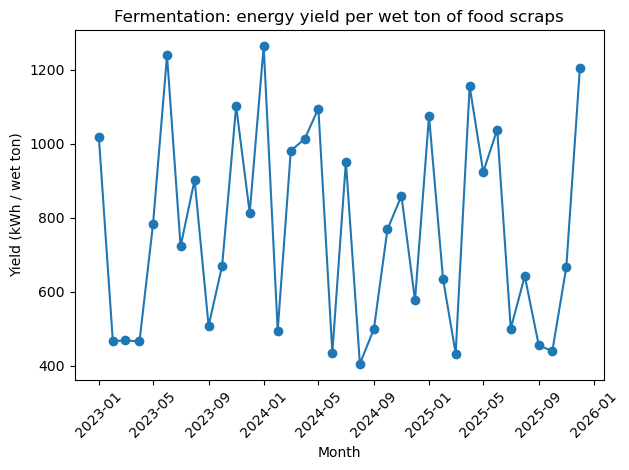

Fitted model: rng_kWh ≈ alpha*food + beta*sludge + gamma
alpha = 666.59 kWh/ton_food,  beta = 76.36 kWh/ton_sludge,  gamma = -4559043.36 kWh


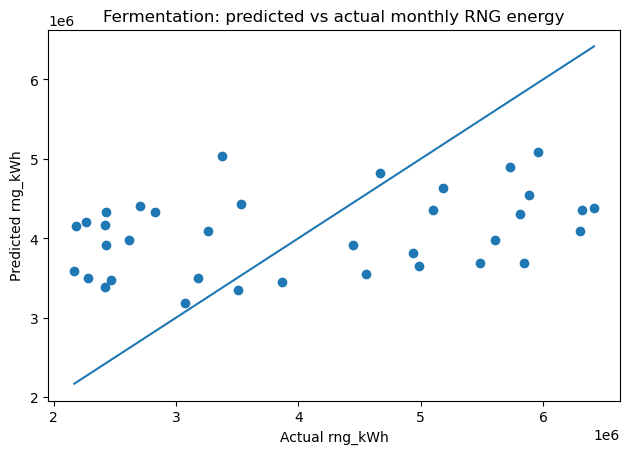

,mean,std,count
year,,,
2023,763.399470,264.041438,12
2024,778.750572,289.825763,12
2025,764.192885,296.104348,12


In [8]:
TECH = "Fermentation"
if TECH == "Fermentation":
    df_f = df.copy()

    # === TODO: conversion factor (provided here as a constant from unit conversion tables) ===
    # 1 MMBtu ≈ 293.071 kWh
    MMBtu_to_kWh = 293.071

    # Convert RNG production to energy (kWh)
    df_f["rng_kWh"] = df_f["rng_production_mmbtu"] * MMBtu_to_kWh

    # --- Yield metrics ---
    # NOTE: "wet tons" are not the same as dry mass / volatile solids.
    # We use wet tons because that is what the dataset provides.
    df_f["food_wet_tons"] = df_f["food_scraps_digested_wet"]
    df_f["sludge_wet_tons"] = df_f.get("sludge_digested_wet_tons", np.nan)

    # Energy yield per ton (kWh / wet ton)
    df_f["Y_food_kWh_per_ton"] = df_f["rng_kWh"] / df_f["food_wet_tons"]
    df_f["Y_total_kWh_per_ton"] = df_f["rng_kWh"] / (df_f["food_wet_tons"] + df_f["sludge_wet_tons"])

    # Uptime-adjusted yields (crude): divide by uptime fraction
    # If uptime is 80%, then observed production is ~80% of what it would be at 100%,
    # assuming inputs and biology were otherwise comparable (this assumption is debatable).
    uptime_frac = df_f["rng_system_uptime"] / 100.0
    df_f["Y_food_adj_kWh_per_ton"] = df_f["Y_food_kWh_per_ton"] / uptime_frac

    display(df_f[["year","month","food_wet_tons","sludge_wet_tons","rng_production_mmbtu","rng_kWh",
                  "rng_system_uptime","Y_food_kWh_per_ton","Y_total_kWh_per_ton","Y_food_adj_kWh_per_ton"]].head())

    # Plot yield over time
    # Create a sortable date index (approximate) from year+month
    month_order = {m:i+1 for i,m in enumerate(
        ["January","February","March","April","May","June","July","August","September","October","November","December"]
    )}
    df_f["month_num"] = df_f["month"].map(month_order)
    df_f["date"] = pd.to_datetime(dict(year=df_f["year"], month=df_f["month_num"], day=1))

    df_f = df_f.sort_values("date")

    plt.figure()
    plt.plot(df_f["date"], df_f["Y_food_kWh_per_ton"], marker="o", linestyle="-")
    plt.title("Fermentation: energy yield per wet ton of food scraps")
    plt.xlabel("Month")
    plt.ylabel("Yield (kWh / wet ton)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Simple linear regression: rng_kWh ~ alpha*food + beta*sludge + gamma ---
    # We fit using ordinary least squares.
    # If sludge_wet_tons has missing values, we drop those rows for the regression.
    df_reg = df_f.dropna(subset=["food_wet_tons","sludge_wet_tons","rng_kWh"]).copy()

    X = np.column_stack([
        df_reg["food_wet_tons"].to_numpy(),
        df_reg["sludge_wet_tons"].to_numpy(),
        np.ones(len(df_reg))
    ])
    y = df_reg["rng_kWh"].to_numpy()

    # Least squares solution
    coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
    alpha, beta, gamma = coeff

    print(f"Fitted model: rng_kWh ≈ alpha*food + beta*sludge + gamma")
    print(f"alpha = {alpha:.2f} kWh/ton_food,  beta = {beta:.2f} kWh/ton_sludge,  gamma = {gamma:.2f} kWh")

    # Predicted vs actual plot
    yhat = X @ coeff
    plt.figure()
    plt.scatter(y, yhat)
    lo, hi = float(min(y.min(), yhat.min())), float(max(y.max(), yhat.max()))
    plt.plot([lo,hi],[lo,hi])
    plt.title("Fermentation: predicted vs actual monthly RNG energy")
    plt.xlabel("Actual rng_kWh")
    plt.ylabel("Predicted rng_kWh")
    plt.tight_layout()
    plt.show()

    # Optional: yearly yield summary
    yearly = df_f.groupby("year")["Y_food_kWh_per_ton"].agg(["mean","std","count"])
    display(yearly)


## Branch: Nuclear fission

### Modelling idea

A nuclear plant is typically treated as **baseload**: power is near-constant when operating, with occasional outages.

In this dataset:
- `capacity_MW` is nameplate capacity
- `power_MW` is hourly output (including outage periods)

### Your task

1. Compute an approximate **capacity factor**:
$$
\text{CF} = \frac{\int P(t)dt}{\int P_{\max} dt}
$$
2. Convert annual energy to MWh or GWh.
3. Add one plot (e.g., 30-day window) showing outages and interpret.

Reference: capacity factor definition (EIA):  
- https://www.eia.gov/tools/faqs/faq.php?id=101&t=3



<b> Please note, I have altered the synthetic nuclear fission data to fit what would be expected of a Small Modular Reactor (SMR), which is 1/10th the capacity of what the synthetic data was initially created for, which is what my group is focusing on for 
phase 2 of RP3 as we believe it better suits the energy needs of Corner Brook. Since SMRs are currently in early phases of testing/implementation there 
is no open-source data available. Instead, all synthetic power and capacity data was brought to 10% of their initial values since SMRs generally have a capacity of 
up to 300 MW, so by multiplying everything by 0.1, capacity went from 1000 to 300 MW; power data was also adjusted accordingly.

In [98]:
TECH = "Nuclear Fission"
def load_data_for_tech(tech: str) -> pd.DataFrame:
    """Load the packaged dataset associated with a technology choice."""
    if tech in ["Solar","Wind"]:
        return pd.read_csv(DATA_DIR / "hamilton_2025_wind_solar_openmeteo.csv", parse_dates=["time"])
    if tech == "Fermentation":
        return pd.read_csv(DATA_DIR / "nyc_wrrf_biogas_monthly_sample.csv")
    if tech == "Water":
        return pd.read_csv(DATA_DIR / "water_daily_flow_synthetic_2025.csv", parse_dates=["date"])
    if tech == "Nuclear Fission":
        return pd.read_csv(DATA_DIR / "nuclear_hourly_synthetic_2025.csv", parse_dates=["time"])
    if tech == "Geothermal":
        return pd.read_csv(DATA_DIR / "geothermal_hourly_synthetic_2025.csv", parse_dates=["time"])
    raise ValueError(f"Unknown tech: {tech}")

'''
Please note, I have altered the synthetic nuclear fission data to fit what would be expected of a Small Modular Reactor (SMR), which is what my group is focusing on for 
phase 2 of RP3 as we believe it better suits the energy needs of Cornerbrook. Since SMRs are currently in early phases of testing/implementation there 
is no open-source data available. Instead, all synthetic power and capacity data was brought to 30% of their initial values since SMRs generally have a capacity of 
up to 300 MW, so by multiplying everything by 0.3 capacity went from 1000 to 300 MW and power data was also adjusted accordingly.
'''

df = load_data_for_tech(TECH)
df.head()


,time,power_MW,capacity_MW
0,2025-01-01 00:00:00,96.394,100
1,2025-01-01 01:00:00,95.356,100
2,2025-01-01 02:00:00,95.598,100
3,2025-01-01 03:00:00,97.809,100
4,2025-01-01 04:00:00,0.000,100


Annual energy: 2,734,641.3 GWh
Capacity factor: 0.867


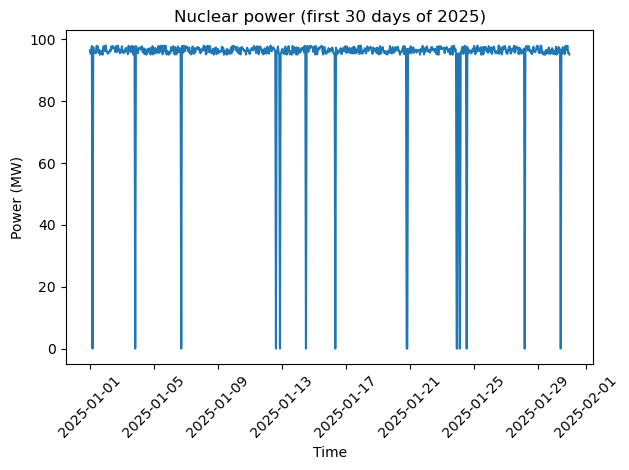

In [10]:
if TECH == "Nuclear Fission":
    df_n = df.copy()
    P = df_n["power_MW"].to_numpy()
    Pmax = df_n["capacity_MW"].to_numpy() # maximum possible power
    # dt is 1 hour
    E_MWh = trapz_integral(P,dt=3600)
    E_GWh = E_MWh / 1000.0 # convert to GWh
    CF = E_MWh/(trapz_integral(Pmax, dt=3600)) # TODO: compute capacity factor using E_MWh and the integral of Pmax
    print(f"Annual energy: {E_GWh:,.1f} GWh")
    print(f"Capacity factor: {CF:.3f}")

    window = df_n.iloc[0:24*30].copy()
    plt.figure()
    plt.plot(window["time"], window["power_MW"])
    plt.title("Nuclear power (first 30 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Geothermal

### Modelling idea

Geothermal plants are also often **baseload**, but output can vary due to maintenance, resource temperature changes, and plant operations.

Tasks are similar to nuclear:
1. Compute annual energy.
2. Compute capacity factor.
3. Plot a window and interpret.

Reference (general geothermal overview):  
- US DOE Geothermal basics: https://www.energy.gov/eere/geothermal/geothermal-basics



In [11]:
if TECH == "Geothermal":
    df_g = df.copy()
    P = df_g["power_MW"].to_numpy()
    Pmax = df_g["capacity_MW"].to_numpy() # maximum possible power
    E_MWh = np.nan # TODO: compute annual energy in MWh using trapz_integral on P with dt=3600 seconds
    CF = np.nan # TODO: compute capacity factor using E_MWh and the integral of Pmax
    print(f"Annual energy: {E_MWh/1000:,.1f} GWh")
    print(f"Capacity factor: {CF:.3f}")

    window = df_g.iloc[0:24*30].copy()
    plt.figure()
    plt.plot(window["time"], window["power_MW"])
    plt.title("Geothermal power (first 30 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Water (hydro)

### Modelling idea

Hydro power depends on flow rate $Q$ and head $H$:
$$
P = \eta\,\rho\,g\,Q\,H
$$
where
- $Q$ is flow (m³/s),
- $H$ is head (m),
- $\rho$ is water density (~1000 kg/m³),
- $g\approx 9.81\,\text{m/s}^2$.

The dataset provides a daily flow time series `flow_m3_s`. (This is a representative profile packaged with the notebook.)

Reference: US DOE hydropower basics:  
- https://www.energy.gov/eere/water/hydropower-basics

### Your task

1. Choose plausible $H$ and efficiency $\eta$.
2. Compute daily power and annual energy.
3. Plot seasonal variation and interpret.



In [12]:
if TECH == "Water":
    df_w = df.copy()
    rho = np.nan  # TODO: water density (kg/m^3)
    g = np.nan  # TODO: gravitational acceleration (m/s^2)
    eta = np.nan  # TODO: efficiency (dimensionless)
    H = np.nan  # TODO: head (m)

    if np.isnan(rho) or np.isnan(g) or np.isnan(eta) or np.isnan(H):
        raise ValueError("Set rho, g, eta, H (and justify) before running the Water branch.")

    Q = df_w["flow_m3_s"].to_numpy()
    P_W = np.nan  # TODO: compute hydro power in Watts using rho, g, eta, H, and Q
    df_w["power_MW"] = P_W / 1e6 #convert to MW

    # daily samples: dt = 1 day
    dt_seconds = 24*3600
    E_MWh = np.nan # TODO: compute annual energy in MWh using trapz_integral on df_w["power_MW"] with dt=dt_seconds
    print(f"Annual energy: {E_MWh/1000:,.1f} GWh")

    plt.figure()
    plt.plot(df_w["date"], df_w["power_MW"])
    plt.title("Hydro power estimate (daily)")
    plt.xlabel("Date")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Phase 2 — Dynamical modelling with an ODE (storage, balancing, and reliability)

Phase 1 focused on computing energy by integrating a power time series.  
Phase 2 adds **dynamics**: what happens over time when supply and demand do not match perfectly?

Many energy systems include something that **accumulates** or **buffers** energy (battery, hydrogen tank, pumped hydro reservoir, thermal storage).  
A natural mathematical language for “accumulation over time” is a **differential equation**.

---

## What is $S(t)$?

Let $S(t)$ denote the **stored energy** at time $t$.

- Units: **Joules (J)**.  
- Interpretation: how much usable energy is currently stored.

Because $S(t)$ is energy, it has a **maximum capacity**:

- $S_{\max}$ (J): the **storage capacity**, i.e. the largest energy the storage can hold.

When we plot $S(t)$, we often convert units to something more intuitive like **MWh**:
- $1\ \text{MWh} = 3.6\times 10^9\ \text{J}$.

---

## A minimal storage ODE

If $P_{\text{in}}(t)$ is the electrical power *going into* storage (W) and $P_{\text{out}}(t)$ is the power *leaving* storage (W), then

$$
\frac{dS}{dt} = P_{\text{in}}(t) - P_{\text{out}}(t).
$$

- If $P_{\text{in}}(t) > P_{\text{out}}(t)$ then $S(t)$ increases (charging).
- If $P_{\text{in}}(t) < P_{\text{out}}(t)$ then $S(t)$ decreases (discharging).
- If they are equal, $S(t)$ stays constant.

In practice, storage also has constraints:

- **Capacity constraint:** $0 \le S(t) \le S_{\max}$
- **Charge-rate constraint:** $P_{\text{in}}(t) \le P_{\text{charge,max}}$
- **Discharge-rate constraint:** $P_{\text{out}}(t) \le P_{\text{discharge,max}}$

Here:
- $P_{\text{charge,max}}$ (W) is the **maximum charging power**.
- $P_{\text{discharge,max}}$ (W) is the **maximum discharging power**.

These are engineering constraints: you cannot charge or discharge infinitely fast.

---

## What are we doing in this notebook?

We will:
1. Create a simple **demand** time series (a toy model).
2. Use your technology’s power time series as the **supply**.
3. Simulate how storage can help meet demand over time.
4. Quantify reliability: “What fraction of the time is demand met?”

This is not a full power-grid model. It is a **transparent, minimal model** that connects:
- calculus (integrating power),
- ODEs (accumulation),
- and interpretation (feasibility and constraints).

---

## Optional extension (not required): first-order lag / ramping

Some technologies cannot change output instantly. A very simple “ramping” model is

$$
\tau \frac{dP}{dt} + P = P_{\text{target}}(t),
$$

where $\tau$ is a time scale describing how quickly the system responds.  
This notebook does **not** require you to use this model, but it is a natural extension if your group wants to discuss ramp limits or smoothing.

Reference (short, reputable): SciPy ODE solving documentation  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


## Converting your dataset into a common power time series

Different technologies come with different raw data:

- Solar: irradiance (W/m²)
- Wind: wind speed (m/s)
- Water: flow rate (m³/s)
- Nuclear/Geothermal: power output already (MW)
- Fermentation: monthly energy production (MMBtu)

For Phase 2 we want a **single common object** regardless of technology:

> an hourly power time series $P_{\text{supply}}(t)$ in **Watts (W)**.

The function below performs that conversion.  
**You generally do not need to edit the function.** Instead, you will edit the **parameter choices** inside your technology branch in Phase 1 (efficiency, area, head, etc.).

If you *do* want to refine the model (optional), this function is the place where you would upgrade the mapping from “resource data” → “power”.

### Your task (write in the answer block after the cell)
- In one paragraph: explain what the function is doing for **your** technology.
- State what assumptions it makes (e.g., constant efficiency, simple caps, daily upsampling).


In [29]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
# Note: if you get an error saying that there is no module named 'scipy', you may need to install scipy in your Python environment.



def get_power_timeseries_W(tech: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Return (t_hours, P_W) for the chosen tech, aligned to an hourly grid when possible."""
    
    if tech == "Nuclear Fission":
        P_W = df["power_MW"].to_numpy() * 1e6
        t_hours = np.arange(len(P_W), dtype=float)

        return t_hours, P_W

t_hours, Pin = get_power_timeseries_W(TECH, df)
len(t_hours), Pin[:40]

(8760,
 array([96394000., 95356000., 95598000., 97809000.,        0., 97460000.,
        96348000., 95630000., 95632000., 95425000., 97858000., 97461000.,
        97661000., 95694000., 96458000., 95011000., 96352000., 95422000.,
        95948000., 95005000., 97517000., 97779000., 97705000., 96117000.,
        97996000., 96082000., 95825000., 95305000., 95857000., 95748000.,
        96533000., 96120000., 97653000., 96893000., 97822000., 97159000.,
        97197000., 97258000., 95859000., 97780000.]))

### Answer (Phase 2.1)
For nuclear fission, the conversion function takes the plant’s reported electrical output, which is already given in megawatts, and turns it into a uniform hourly power time series $P_{\text{supply}} (t)$ in watts. It reads the power column from the dataset,  and rescales from MW to W so that all later calculations use consistent SI units. The function treats each hourly power value as applying to the entire hour (piecewise‑constant in time), which means any faster ramping or short outages within an hour are not resolved and are effectively averaged into the hourly series. This is fairly accurate to SMRs which can ramp to full capacity in timescales much less than an hour, ramping at 60%/min.

## Build a toy demand profile

To keep this notebook self-contained, we use a **toy demand profile**:
- a baseline demand
- plus a daily cycle (higher during daytime)
- plus random noise

You can edit it to match your project location. The following cell is an example. You can change it as you see fit. 


Determining Demand: 
We start with the total annual energy consumption given in gigajoules:
$
E_{\text{year}} = 591{,}423.687 \ \text{GJ}.
$

Since \(1 \ \text{GJ} = 10^9 \ \text{J}\), convert gigajoules to joules:
$
E_{\text{year}} = 591{,}423.687 \times 10^9 \ \text{J}.
$

To convert joules to watt-hours, we use the relation
\(1 \ \text{Wh} = 3600 \ \text{J}\):
$
E_{\text{year}} = \frac{591{,}423.687 \times 10^9}{3600} \ \text{Wh}.
$

Evaluating this gives the total annual energy in watt-hours:
$
E_{\text{year}} \approx 1.64284 \times 10^{11} \ \text{Wh}.
$

Because this energy is consumed over an entire year, we divide by the
number of hours in a year (\(8760\)) to find the average hourly energy use:
$
E_{\text{hour}} = \frac{1.64284 \times 10^{11}}{8760}
\approx 1.875 \times 10^{7} \ \text{Wh}.
$

This corresponds to an average power demand of:
$
P_{\text{avg}} \approx 18.75 \ \text{MW}.
$


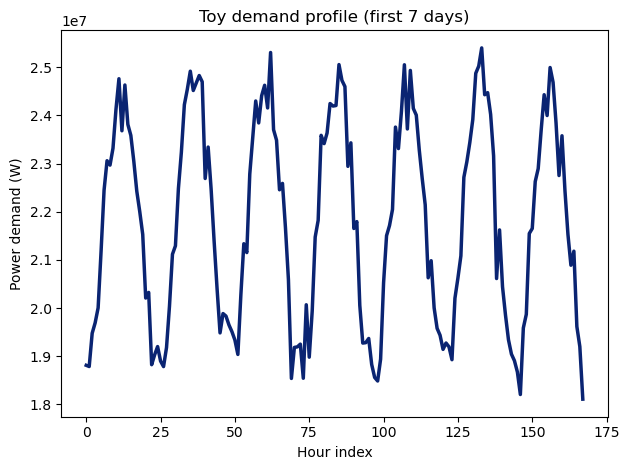

In [14]:
rng = np.random.default_rng(0)

'''The breakdown of different housing types and their amounts in Cornerbrook were sourced from Statistics Canada. 
   Then, using the average annual electricity consumption for those housing types in Canada, per house, published by Statistics Canada, was 
   used to estimate electricity demand in Cornerbrook, Newfoundland. This was then divided by 364*24 to obtain the estimated hourly energy consumption of electricity.'''
baseline_W = (1.875*10**7)


'''Daily hydro load, as sourced from NL Hydro's public website, which is where Cornerbrook gets the majority of its electricity from seems to vary by about 25-40% per day. 
   So it is assumed that electricity demand in Cornerbrook also varies by about 25-40% per day as well. Hence, an average number of the two (32.5%) has been chosen.'''
daily_amp_W = (1.875*10**7)*0.325 


if np.isnan(baseline_W) or np.isnan(daily_amp_W):
    raise ValueError("Set baseline_W and daily_amp_W (and justify) before running the demand model.")

# Build a daily sinusoid with period 24 hours
demand = baseline_W + daily_amp_W * (0.5 + 0.5*np.sin(2*np.pi*(t_hours/24.0 - 0.25)))
demand = demand + rng.normal(0, 5e5, size=len(demand))  # noise
demand = np.clip(demand, 0, None)

plt.figure()
plt.plot(t_hours[:24*7], demand[:24*7],color="#0A2472", linewidth=2.5 )
plt.title("Toy demand profile (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Power demand (W)")
plt.tight_layout()
plt.show()

### Answer (Phase 2.2)

*Describe what your toy demand represents and what its limitations are. If you change parameters (baseline, amplitude), justify briefly.*

This toy demand model represents estimated residential electricity demand in Cornerbrook, Newfoundland. It has been calculated by determining how many of each type of dwelling occurs in Cornerbrook (e.g. single-detatched, double, etc.) and then estimating consumption utilizing published values from Statistics Canada on average annual electricity consumption by these dwelling-types. This limits the accuracy of this model in that it does not exactly model the electricity consumption of Cornerbrook, and simply provides a general idea of how much the city may consume. Further, this model only focuses on residential electricity demand given that the intention of this project is to suggest a type of technology capapble of supporting a community housing initiative, so does not accurately model all electrical demand in Cornerbrook as it fudnmentallly does not utilize any data for industrial demand. The model is sinusodial and has a period of 24 hours to model residential electrical demand throughout the day, so it peaks during the day and dips during the night. However, after observing NL Hydros electrical demand over a period of time it was evident that there were two peaks present each day spaced a few hours apart, assuming this also occurs in Cornerbrook, this model does a poor job of modelling the second peak.  

Justifying baseline demand: The breakdown of different housing types and their amounts in Cornerbrook were sourced from Statistics Canada. Then, using the average annual electricity consumption for those housing types in Canada, per house, published by Statistics Canada, was used to estimate electricity demand in Cornerbrook, Newfoundland. This was then divided by 364*24 to obtain the estimated hourly energy consumption of electricity.

Justifying amplitude: Daily hydro load, as sourced from NL Hydro's public website, which is where Cornerbrook gets the majority of its electricity from seems to vary by about 25-40% per day. So it is assumed that electricity demand in Cornerbrook also varies by about 25-40% per day as well. Hence, an average number of the two (32.5%) was chosen. So the amplitude is 32.5% of the baseline demand to accurately model this - but this is also an oversimplifciation since it varies by a different amount each day so a more accurate model would likely randomly choose from the 25-40% range each day.

## Storage dispatch model used below

We have:
- **Supply** $P_{\text{supply}}(t)$ (W): produced by your technology (from the earlier conversion cell).
- **Demand** $P_{\text{demand}}(t)$ (W): the load the community/system needs at time $t$.
- **Stored energy** $S(t)$ (J): how much energy is currently stored.

At each time step (1 hour), we follow this simple logic:

1. If supply exceeds demand, use supply to meet demand and put the surplus into storage (charging), up to:
   - the storage capacity $S_{\max}$ and
   - the charge-rate limit $P_{\text{charge,max}}$.
2. If supply is less than demand, discharge storage to try to cover the deficit, up to:
   - the available stored energy $S(t)$ and
   - the discharge-rate limit $P_{\text{discharge,max}}$.

This produces a time series $S(t)$ and a binary indicator: **did we meet demand at that hour?**

### Why choose $S_{\max}$?

Choosing $S_{\max}$ is a modelling decision: it encodes how much storage infrastructure you are assuming.
A useful interpretation is “how many hours of baseline demand can the storage cover?”

Example: if baseline demand is 2 MW, then 4 hours of coverage corresponds to:
$$
S_{\max} = (2\times 10^6\ \text{W})\cdot (4\ \text{h}) = 8\times 10^6\ \text{Wh} = 8\ \text{MWh}.
$$
In Joules, that is $8\ \text{MWh}\times 3.6\times 10^9\ \text{J/MWh}$.

### Your task (answer block below)
- Explain your chosen values of $S_{\max}$, $P_{\text{charge,max}}$, and $P_{\text{discharge,max}}$.
- Give a short “engineering meaning” (e.g., hours of coverage, plausible charge/discharge rate).


Our group is researching small modular reactors (SMRs) that use molten-salt systems to store thermal energy, which can later be converted into electricity by driving a turbine. 
Current molten-salt storage systems are typically designed to provide approximately four hours of coverage at baseline demand.

Using the baseline power demand for Corner Brook,
$
P_{\text{base}} \approx 1.875 \times 10^{7} \ \text{W},
$
the total energy required for four hours of coverage is
$
S_{\max} = 4 \times P_{\text{base}} \times 3600
= 4 \times (1.875 \times 10^{7}) \times 3600
\approx 2.70 \times 10^{11} \ \text{J}.
$

Hence, the chosen value of the maximum storage capacity is
$
S_{\max} = 2.70 \times 10^{11} \ \text{J}.
$
This implies that if the SMR’s nuclear reactions were halted, the thermal storage system could continue supplying Corner Brook with electricity for approximately four additional hours.

\subsection*{Charging and Discharging Power}

Coupled molten-salt storage systems typically employ heating and cooling rates of \(8^\circ\text{C}\)/minute and utilize a mixture of nitrate salts for thermal energy storage. 
For the purposes of this model, we assume a salt composition ratio of
$
32:24:44 \quad (Ca(NO_3)_2 : NaNO_3 : KNO_3),
$
as this proportion is considered optimal for latent heat storage. 
When in the liquid state, this mixture has a specific heat capacity of
$
c = 1.2 \ \text{J}\,(\text{g}\cdot^\circ\text{C})^{-1}
= 1200 \ \text{J}\,(\text{kg}\cdot^\circ\text{C})^{-1}.
$

A storage plant of comparable size has previously required approximately
$
m = 2.9715 \times 10^{7} \ \text{kg}
$
of this molten-salt mixture. 
Using the heating and cooling rate, the temperature change over one second is
$
\Delta T = \frac{8}{60} \approx 0.133^\circ\text{C}.
$

The thermal energy transferred in one second is therefore
$
Q = mc\Delta T
= (2.9715 \times 10^{7})(1200)(0.133)
= 4.742514 \times 10^{9} \ \text{J}.
$

Since this energy transfer occurs over a one-second interval, the corresponding power is
$
P = \frac{Q}{\Delta t}
= \frac{4.742514 \times 10^{9}}{1}
= 4.742514 \times 10^{9} \ \text{W}.
$

Thus,
$
P_{\text{charge}} = P_{\text{discharge}} = 4.742514 \times 10^{9} \ \text{W}.
$

This indicates that the molten-salt storage system can transition rapidly between charging and discharging states, allowing energy to be stored or released quickly. 
As a result, SMRs coupled with thermal storage can respond effectively to sudden increases or decreases in electricity demand, improving grid flexibility and stability.

Fraction of hours demand met: 0.918


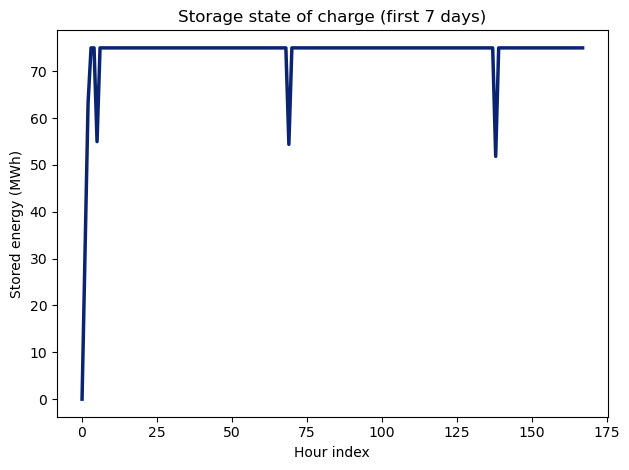

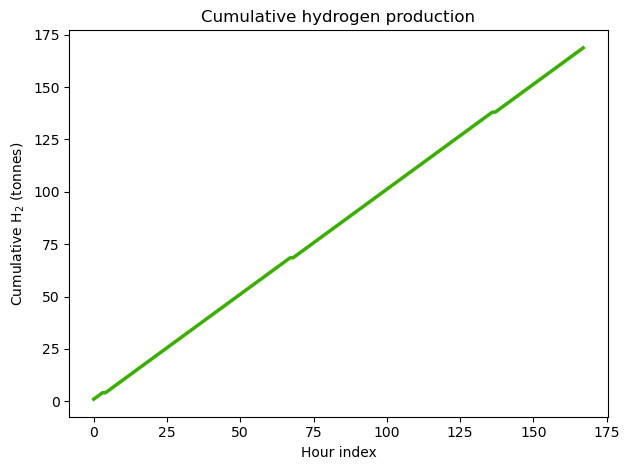

In [ ]:
S_max_J = (1.875*10**7)*4*3600     # storage capacity (J)
P_charge_max = 4.742514e9   # max charge power (W)
P_discharge_max = 4.742514e9

dt = 3600.0  # seconds per step (hourly)

S = np.zeros(len(t_hours))
met = np.zeros(len(t_hours), dtype=bool)

# HTSE parameters
P_htse_elec_max = 45.5e6   # W 
'''
Other solid electrolyzer cells (responsible for electorlyzing H2O to form H2 and O2), have in the past had insantaneous electrical 
input of 45.5e6 watts. https://www.sciencedirect.com/science/article/pii/S2772783125000470?via%3Dihub#sec3.2
'''

P_htse_heat_max = 1e7   # W
'''corresponding to about 3.5% of the ARC‑100’s 286 MW_th core power.
    Nuclear–HTSE cogeneration studies routinely consider partial steam/heat extraction, for example, cases with 15% and 50% of reactor 
    thermal power diverted to HTSE from an LWR, and INL hybrid analyses treat HTSE as a limited‑capacity thermal sink within a larger 
    power plant. Our 3.5% extraction is therefore a conservative, small‑fraction coupling consistent with this literature.'''

sec = 44.5 * 3.6e6        # J/kg (electricity required per kg of H2) https://iea.blob.core.windows.net/assets/cb9d5903-0df2-4c6c-afa1-4012f9ed45d2/GlobalHydrogenReview2023.pdf 
sth = 6.4 * 3.6e6        # J/kg (thermal energy required per kg of H2) https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_60759.pdf 

h2_produced = np.zeros(len(t_hours))

# ARC-100 thermal side
thermal_efficiency = 0.39 # Source: https://www.osti.gov/servlets/purl/2583878 
Pthermal_in = Pin / thermal_efficiency           # W, varies with reactor power
P_turbine_min = demand / thermal_efficiency      # W, thermal needed for that demand

for k in range(1, len(t_hours)):
    # recompute surplus inside loop
    surplus = Pin[k-1] - demand[k-1]
    elec_surplus = surplus
    heat_surplus = Pthermal_in[k-1] - P_turbine_min[k-1]

    if elec_surplus >= 0 and heat_surplus >= 0:
        # HTSE priority
        elec_to_htse = min(elec_surplus, P_htse_elec_max)
        heat_to_htse = min(heat_surplus, P_htse_heat_max)
        rate_limit = min(elec_to_htse/sec, heat_to_htse/sth)
        h2_produced[k-1] = rate_limit * dt  # kg in this hour

        # Remaining to storage (using electrical surplus for now)
        elec_remain = elec_surplus - elec_to_htse
        charge = min(elec_remain, P_charge_max)
        S[k] = min(S_max_J, S[k-1] + charge * dt)
        supplied = demand[k-1]  # demand is fully met
        met[k-1] = True

    else:
        # deficit side: storage discharging
        need = -surplus
        discharge = min(need, P_discharge_max, S[k-1] / dt)
        supplied = Pin[k-1] + discharge
        S[k] = max(0.0, S[k-1] - discharge * dt)
        met[k-1] = supplied >= demand[k-1] - 1e-6


fraction_met = met.mean()
print(f"Fraction of hours demand met: {fraction_met:.3f}")

plt.figure()
plt.plot(t_hours[:24*7], S[:24*7] / 3.6e9, color="#0A2472", linewidth=2.5)
plt.title("Storage state of charge (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.tight_layout()
plt.show()

cum_h2_tonnes = h2_produced.cumsum() / 1000.0

plt.figure()
plt.plot(t_hours[:24*7], cum_h2_tonnes[:24*7], color="#38B000", linewidth=2.5)
plt.title("Cumulative hydrogen production")
plt.xlabel("Hour index")
plt.ylabel("Cumulative H$_2$ (tonnes)")
plt.tight_layout()
plt.show()

## Numerically solving the ODE with `solve_ivp` (required)

The loop above is a **discrete-time simulation** (hour-by-hour bookkeeping).  
In this section you will also solve a **continuous-time ODE** using SciPy.

### ODE we solve

We model stored energy $S(t)$ (J) with:

$$
\frac{dS}{dt} = u(t),
$$

where $u(t)$ is the **net charging power** (W) after applying rate limits and storage bounds.

Let $P_{\text{supply}}(t)$ be supply and $P_{\text{demand}}(t)$ be demand. Define the unconstrained net power:
$$
u_0(t) = P_{\text{supply}}(t) - P_{\text{demand}}(t).
$$

We then apply the **power limits**:
- charging cannot exceed $P_{\text{charge,max}}$
- discharging cannot exceed $P_{\text{discharge,max}}$

and also prevent $S(t)$ from leaving $[0,S_{\max}]$ by setting $u(t)=0$ when the storage is full and would charge, or empty and would discharge.

### Your task
- Run the ODE solver and compare its $S(t)$ curve to the discrete simulation.
- Briefly explain why the curves may not match exactly (hint: discretization, piecewise definitions, interpolation).


solve_ivp success: True
solve_ivp message: The solver successfully reached the end of the integration interval.


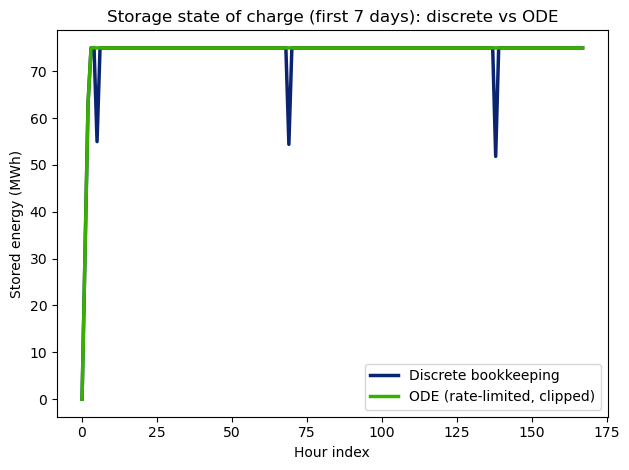

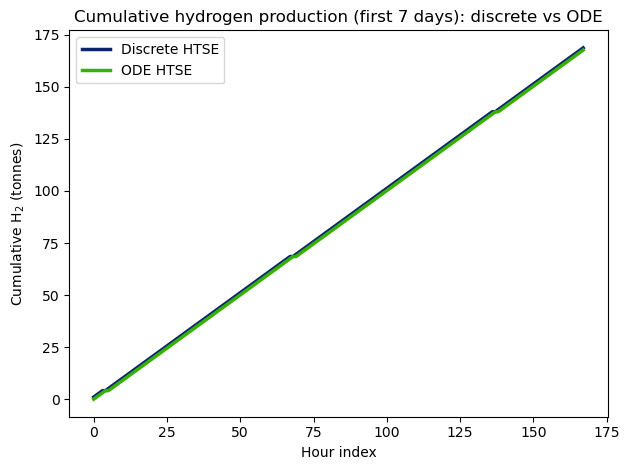

In [16]:
t_sec = t_hours * 3600.0

# Piecewise-constant interpolation for electrical and thermal quantities
Pin_fun       = interp1d(t_sec, Pin, kind="previous", fill_value="extrapolate")
demand_fun    = interp1d(t_sec, demand, kind="previous", fill_value="extrapolate")
Pthermal_fun  = interp1d(t_sec, Pthermal_in, kind="previous", fill_value="extrapolate")
Pturb_min_fun = interp1d(t_sec, P_turbine_min, kind="previous", fill_value="extrapolate")

def htse_powers_and_h2_rate(t):
    """
    Given time t (s), compute:
      - P_htse_elec_used: electrical power actually sent to HTSE (W)
      - h2_rate: hydrogen production rate (kg/s)
    using the same surplus-based logic as the discrete model.
    """
    P_el = float(Pin_fun(t))              # electrical supply (W)
    P_load = float(demand_fun(t))         # electrical demand (W)
    P_th = float(Pthermal_fun(t))         # thermal available (W)
    P_th_turb_min = float(Pturb_min_fun(t))  # thermal needed for turbine (W)

    elec_surplus = P_el - P_load
    heat_surplus = P_th - P_th_turb_min

    if elec_surplus >= 0 and heat_surplus >= 0:
        elec_to_htse = min(elec_surplus, P_htse_elec_max)
        heat_to_htse = min(heat_surplus, P_htse_heat_max)
        h2_rate = min(elec_to_htse / sec, heat_to_htse / sth)  # kg/s
        P_htse_elec_used = h2_rate * sec
    else:
        h2_rate = 0.0
        P_htse_elec_used = 0.0

    return P_htse_elec_used, h2_rate

def dXdt(t, X):
    """
    ODE state:
      X[0] = S (storage energy, J)
      X[1] = cumulative H2 (kg)
    """
    S_ode, H_ode = X

    P_el = float(Pin_fun(t))
    P_load = float(demand_fun(t))

    # HTSE consumption and hydrogen rate
    P_htse_elec_used, h2_rate = htse_powers_and_h2_rate(t)

    # Net electrical power for storage (or deficit to be covered by storage)
    u0 = P_el - P_load - P_htse_elec_used  # W = J/s

    # Apply charge/discharge power limits (no SoC clipping here)
    u = min(u0, float(P_charge_max))
    u = max(u, -float(P_discharge_max))

    dS_dt = u          # J/s
    dH_dt = h2_rate    # kg/s

    return [dS_dt, dH_dt]


X0 = [0.0, 0.0]

sol = solve_ivp(
    dXdt,
    t_span=(t_sec[0], t_sec[-1]),
    y0=X0,
    t_eval=t_sec,
    method="RK23",
    rtol=1e-4,
    atol=1.0,
    max_step=3600.0,
)

if (not sol.success) or (sol.y is None) or (sol.y.shape[1] != len(t_sec)):
    print("solve_ivp did not succeed; falling back to simple integration.")
    print("Message:", sol.message)
    # Fallback: storage only, no H2 in fallback
    u_hourly = np.clip(Pin - demand, -float(P_discharge_max), float(P_charge_max))
    S_ode_raw = np.concatenate([[0.0], np.cumsum(u_hourly[:-1] * 3600.0)])
    H_ode_raw = np.zeros_like(S_ode_raw)
else:
    S_ode_raw = sol.y[0]
    H_ode_raw = sol.y[1]

# Clip storage to physical bounds for interpretation
S_ode = np.clip(S_ode_raw, 0, float(S_max_J))
H_ode = np.clip(H_ode_raw, 0, None)

print("solve_ivp success:", sol.success)
print("solve_ivp message:", sol.message)

# Storage comparison
plt.figure()
plt.plot(t_hours[:24*7], (S[:24*7] / 3.6e9), label="Discrete bookkeeping", color="#0A2472", linewidth=2.5)
plt.plot(t_hours[:24*7], (S_ode[:24*7] / 3.6e9), label="ODE (rate-limited, clipped)",  color="#38B000", linewidth=2.5,)
plt.title("Storage state of charge (first 7 days): discrete vs ODE")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

# Hydrogen comparison
cum_h2_tonnes_discrete = h2_produced.cumsum() / 1000.0
cum_h2_tonnes_ode = H_ode / 1000.0

plt.figure()
plt.plot(t_hours[:24*7], cum_h2_tonnes_discrete[:24*7], label="Discrete HTSE", color="#0A2472", linewidth=2.5)
plt.plot(t_hours[:24*7], cum_h2_tonnes_ode[:24*7], label="ODE HTSE", color="#38B000", linewidth=2.5)
plt.title("Cumulative hydrogen production (first 7 days): discrete vs ODE")
plt.xlabel("Hour index")
plt.ylabel("Cumulative H$_2$ (tonnes)")
plt.legend()
plt.tight_layout()
plt.show()


### Answer (Phase 2.4)

*Compare the discrete and ODE curves. Why do they differ? Which do you trust more for which purpose?*

The discrete and ODE curves look very different. The discrete curve shows periodic dips when demand exceeds production, indicating energy being withdrawn from storage during deficit hours. In contrast, the ODE curve appears almost constant at about 70 MWh. This happens because the ODE solution is clipped into the range $[0,S_{max}]$ after it has been calculated. To see this behaviour, I temporarily increased the clipping threshold to $1 \times 10^19 \text{J}$ (effectively no capacity limit) and replotted the ODE solution (see below). In this version the ODE state grows roughly linearly and shows small dips at the same times as the discrete curve. Essentially, the ODE does not consider the maximum and minimum thresholds of the storage system, and continues to store any excess energy produced regardless of wether this would occur in reality. In reality, if supply>demand and the system was already at capacity it would not store additional energy - the ODE ignores this. Notably, the discrete curve also clips storage, but it does so everytime it calculates storage using the min() and max() functions in Python, so storage capacity can never be greater than 70MWh or less than 0MWh. Considering that the discrete model more accurately showcases the flux of energy in the storage system on the graph, in that it discharges when demand>supply, I would trust the discrete model more when attempting to determine energy storage levels at any given time.

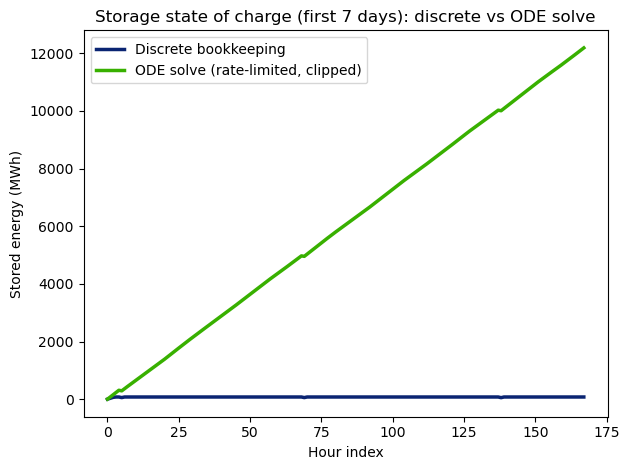

solve_ivp success: True
solve_ivp message: The solver successfully reached the end of the integration interval.


In [17]:
from scipy.interpolate import interp1d

# Hourly samples indexed by t_hours (0,1,2,...) and arrays Pin (supply) and demand.
# Convert to seconds for the ODE solver.
t_sec = t_hours*3600.0

# Use "previous" interpolation so the solver sees piecewise-constant inputs within each hour.
Pin_fun = interp1d(t_sec, Pin, kind="previous", fill_value="extrapolate")
demand_fun = interp1d(t_sec, demand, kind="previous", fill_value="extrapolate")

def dSdt(t, S):
    """dS/dt in J/s. We apply ONLY power-rate limits here.

    Note: enforcing hard bounds (0 <= S <= S_max) directly inside the RHS can create
    discontinuities that make adaptive ODE solvers struggle. We instead:
      1) solve the rate-limited ODE, then
      2) clip S(t) to [0, S_max] for interpretation/plots.
    """
    u0 = float(Pin_fun(t) - demand_fun(t))  # net power (W) = J/s
    # Apply charge/discharge power limits
    u = min(u0, float(P_charge_max))
    u = max(u, -float(P_discharge_max))
    return [u]

# Initial condition (start empty)
S0 = [0.0]

sol = solve_ivp(
    dSdt,
    t_span=(t_sec[0], t_sec[-1]),
    y0=S0,
    t_eval=t_sec,
    method="RK23",
    rtol=1e-4,
    atol=1.0,
    max_step=3600.0,
)

S_ode_raw = sol.y[0] if sol.y is not None else None

# If the solver fails (rare but possible), fall back to a direct numerical integral.
if (not sol.success) or (S_ode_raw is None) or (len(S_ode_raw) != len(t_sec)):
    print("solve_ivp did not succeed; falling back to trapezoid integration.")
    print("Message:", sol.message)
    u_hourly = np.clip(Pin - demand, -float(P_discharge_max), float(P_charge_max))
    S_ode_raw = np.concatenate([[0.0], np.cumsum(u_hourly[:-1] * 3600.0)])

# Clip to physical bounds for interpretation
S_ode = np.clip(S_ode_raw, 0, 10000000000000000000)

plt.figure()
plt.plot(t_hours[:24*7], (S[:24*7] / 3.6e9), label="Discrete bookkeeping", color="#0A2472",linewidth=2.5)
plt.plot(t_hours[:24*7], (S_ode[:24*7] / 3.6e9), label="ODE solve (rate-limited, clipped)", color="#38B000", linewidth=2.5)
plt.title("Storage state of charge (first 7 days): discrete vs ODE solve")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

print("solve_ivp success:", sol.success)
print("solve_ivp message:", sol.message)



### Answer (Phase 2.3)

*Interpret your results. When does the system fail to meet demand? How does changing $S_{\max}$ or the charge/discharge limits affect reliability?*

The SMR fails to meet demand for a few events (8% of events), in these scenarios, energy is excracted from storage. During these events energy storage levels drop from 70MWh to approximately 52MWh. Upon making $S_{\text{max}}$ extremely small, it was found that the SMR failed to meet demand in 10% of cases, which is consistent with the fact that demand only seems to exceed the supply of SMR energy approximately 10% of the time. It was found that if I held storage constant as it is in the model and decreased the charge/discharge limits, then again the system failed ot meet demand in 10% of cases - decreasing reliability. However, if I increased the charge/discharge limits, again holding storage constant (as in the model), by several 10-folds their previous value the reliability still did not increased and remained constant at 91.8%. However, if I increased storage capacity while holding charge/discharge limits constant (as in the model) the reliabilty of the system reached 100%. Hence, if one wanted to maximize the reliability of the system it would likey be done by increasing its storage capacity. That said, this would likely be an extremely costly endeavour and the marginal gains in reliability may not be worth it. 

## Final checklist (before submission)

- [ ] Notebook runs top-to-bottom with no errors.  
- [ ] All **embedded checks** pass.  
- [ ] You wrote short markdown justifications for chosen parameters (efficiency, area, head, storage size, etc.).  
- [ ] You created at least **one plot** that supports interpretation in Phase 1 and **one plot** in Phase 2.  
- [ ] Your group repository is **public** and shared among members; includes `README.md`.  
- [ ] You are ready to cite your repo (link) in the final write-up if you use this work.



<b> Please note this is for the economic analysis part of the RP - not super relavent to the function of this notebook, I just needed to use the hydrogen production data!

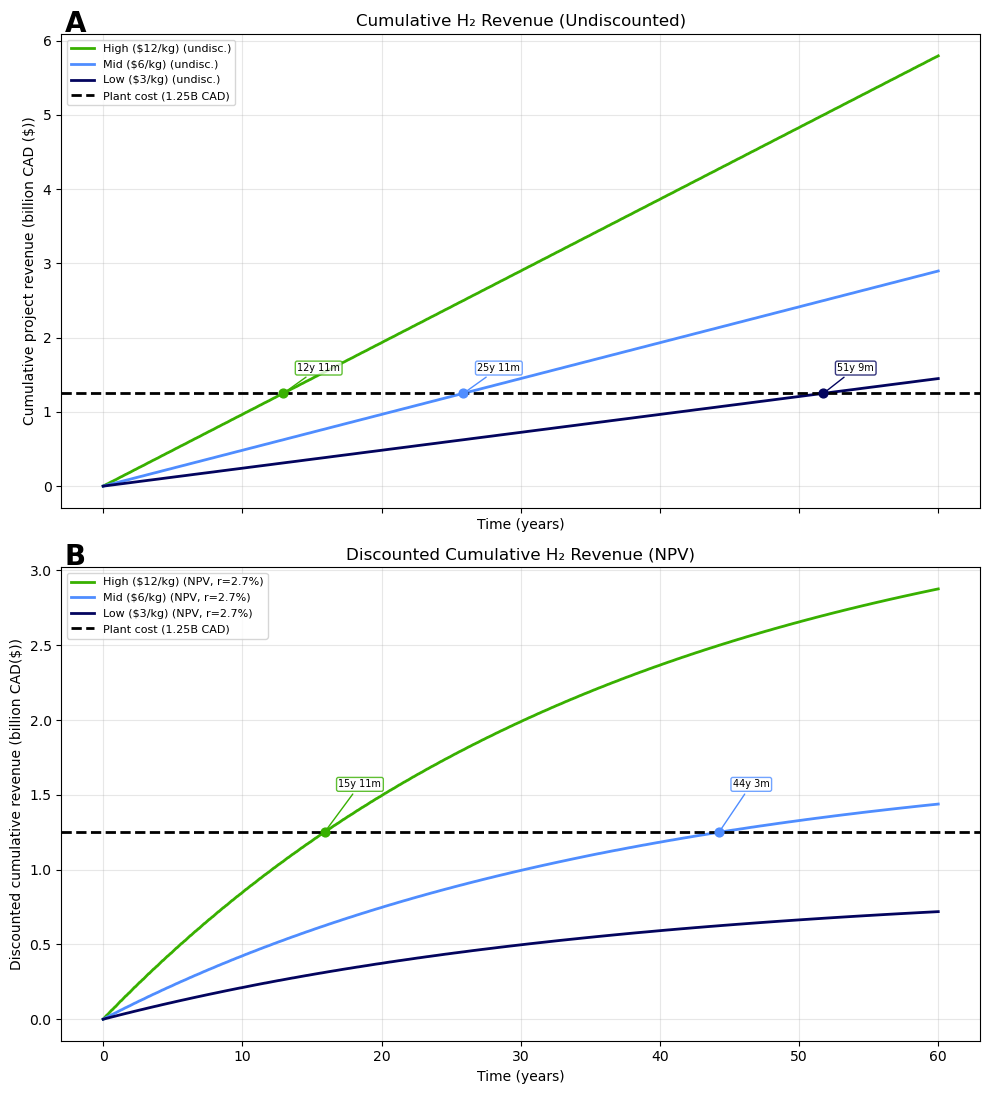

In [97]:
t_hours_60 = np.arange(1, 525600)
Pin_60 = np.tile(Pin,60)
demand_60 = np.tile(demand,60)


Pthermal_in_60 = Pin_60 / thermal_efficiency           # W, varies with reactor power
P_turbine_min_60 = demand_60 / thermal_efficiency


S_60 = np.zeros(len(t_hours_60))
h2_produced_60 = np.zeros(len(t_hours_60))

for k in range(1, len(t_hours_60)):
    # recompute surplus inside loop
    surplus = Pin_60[k-1] - demand_60[k-1]
    elec_surplus = surplus
    heat_surplus = Pthermal_in_60[k-1] - P_turbine_min_60[k-1]

    if elec_surplus >= 0 and heat_surplus >= 0:
        # HTSE priority
        elec_to_htse = min(elec_surplus, P_htse_elec_max)
        heat_to_htse = min(heat_surplus, P_htse_heat_max)
        rate_limit = min(elec_to_htse/sec, heat_to_htse/sth)
        h2_produced_60[k-1] = rate_limit * dt  # kg in this hour

        # Remaining to storage (using electrical surplus for now)
        elec_remain = elec_surplus - elec_to_htse
        charge = min(elec_remain, P_charge_max)
        S_60[k] = min(S_max_J, S_60[k-1] + charge * dt)

    else:
        # deficit side: storage discharging
        need = -surplus
        discharge = min(need, P_discharge_max, S_60[k-1] / dt)
        supplied = Pin_60[k-1] + discharge
        S_60[k] = max(0.0, S_60[k-1] - discharge * dt)


# Full cum H2 tonnes
cum_h2_tonnes_60y = h2_produced_60.cumsum() / 1000.0  # tonnes

# Time in years
t_years = np.arange(len(cum_h2_tonnes_60y)) /8760

# Prices CAD/kg
prices = {'High ($12/kg)': 12, 'Mid ($6/kg)': 6, 'Low ($3/kg)': 3}
colors = {'High ($12/kg)': '#38B000', 'Mid ($6/kg)': "#4F8DFF", 'Low ($3/kg)': '#03045E'}

# Plant cost
plant_cost = 1.25e9  # CAD
r = 0.0269  # discount rate

h2_kg_60y = h2_produced_60
cashflows = {label: h2_kg_60y * price for label, price in prices.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

undisc_cum_rev_lines = {}
disc_cum_rev_lines = {}

for label in prices:
    undisc_cum_rev = np.cumsum(cashflows[label])
    undisc_cum_rev_lines[label] = undisc_cum_rev
    ax1.plot(t_years, undisc_cum_rev / 1e9,
             label=f"{label} (undisc.)",
             color=colors[label], linewidth=2.0)

ax1.axhline(plant_cost / 1e9, color='black', linestyle='--', linewidth=2.0,
            label='Plant cost (1.25B CAD)')

ax1.set_title("Cumulative H₂ Revenue (Undiscounted)")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Cumulative project revenue (billion CAD ($))")
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8)

for label in prices:
    undisc = undisc_cum_rev_lines[label]
    idxs = np.where(undisc >= plant_cost)[0]
    if len(idxs) == 0:
        continue
    idx = idxs[0]
    x = t_years[idx]
    y = undisc[idx] / 1e9
    ax1.scatter(x, y, color=colors[label], s=40, zorder=5)
    total_months = round(x * 12)
    years_i = total_months // 12
    months_i = total_months % 12
    ax1.annotate(
        f"{years_i}y {months_i}m",
        xy=(x, y),
        xytext=(x + 1.0, y + 0.3),
        textcoords="data",
        arrowprops=dict(arrowstyle="-", color=colors[label], lw=1.0),
        fontsize=7,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=colors[label], alpha=0.8),
    )

discount_factors = np.exp(-r * t_years)

for label in prices:
    disc_cashflow = cashflows[label] * discount_factors
    disc_cum_rev = np.cumsum(disc_cashflow)
    disc_cum_rev_lines[label] = disc_cum_rev
    ax2.plot(t_years, disc_cum_rev / 1e9,
             label=f"{label} (NPV, r={r*100:.1f}%)",
             color=colors[label], linewidth=2.0)

ax2.axhline(plant_cost / 1e9, color='black', linestyle='--', linewidth=2.0,
            label='Plant cost (1.25B CAD)')

ax2.set_title("Discounted Cumulative H₂ Revenue (NPV)")
ax2.set_ylabel("Discounted cumulative revenue (billion CAD($))")
ax2.set_xlabel("Time (years)")
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

for label in prices:
    disc = disc_cum_rev_lines[label]
    idxs = np.where(disc >= plant_cost)[0]
    if len(idxs) == 0:
        continue
    idx = idxs[0]
    x = t_years[idx]
    y = disc[idx] / 1e9
    ax2.scatter(x, y, color=colors[label], s=40, zorder=5)
    total_months = round(x * 12)
    years_i = total_months // 12
    months_i = total_months % 12
    ax2.annotate(
        f"{years_i}y {months_i}m",
        xy=(x, y),
        xytext=(x + 1.0, y + 0.3),
        textcoords="data",
        arrowprops=dict(arrowstyle="-", color=colors[label], lw=1.0),
        fontsize=7,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=colors[label], alpha=0.8),
    )


fig.text(0.07, 0.99, "A", ha="left", va="top",fontsize=20, fontweight="bold")  
fig.text(0.07, 0.5051, "B", ha="left", va="top",fontsize=20, fontweight="bold")  

plt.tight_layout()
plt.show()

